# Import Libraries

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# Connect to Quandl and Access NYC Employees Computer Systems Data
https://data.nasdaq.com/data/FRED/SMU36935616054150001SA-all-employees-computer-systems-design-and-related-services-in-new-york-city-ny

I chose this data set since it is also related to employees in the 5 Boroughs of New York City.

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'rvVgyhYNbBqTEzssVcru'

In [4]:
data = quandl.get('FRED/SMU36935616054150001SA')


In [5]:
data.head()

,Value
Date,
1990-01-01,16.295945
1990-02-01,16.128122
1990-03-01,16.049391
1990-04-01,16.120576
1990-05-01,16.096687


In [6]:
data.shape

(384, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

# Build Line Graph of Data

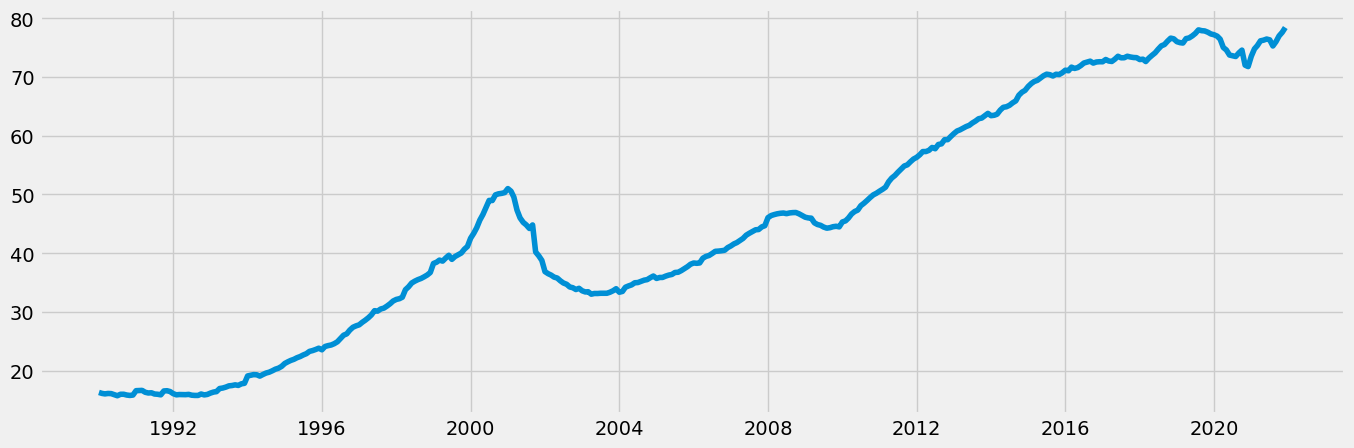

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1990-01-01,16.295945
1,1990-02-01,16.128122
2,1990-03-01,16.049391
3,1990-04-01,16.120576
4,1990-05-01,16.096687


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [13]:
data_sub.shape

(365, 2)

In [14]:
data_sub.head()

,Date,Value
0,1990-01-01,16.295945
1,1990-02-01,16.128122
2,1990-03-01,16.049391
3,1990-04-01,16.120576
4,1990-05-01,16.096687


# Reset Date Index and Build Line Graph
(there is no change in Line Graph from first version to second version, therefore the date index worked properly in the original data set.

In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-01,16.295945
1990-02-01,16.128122
1990-03-01,16.049391
1990-04-01,16.120576
1990-05-01,16.096687


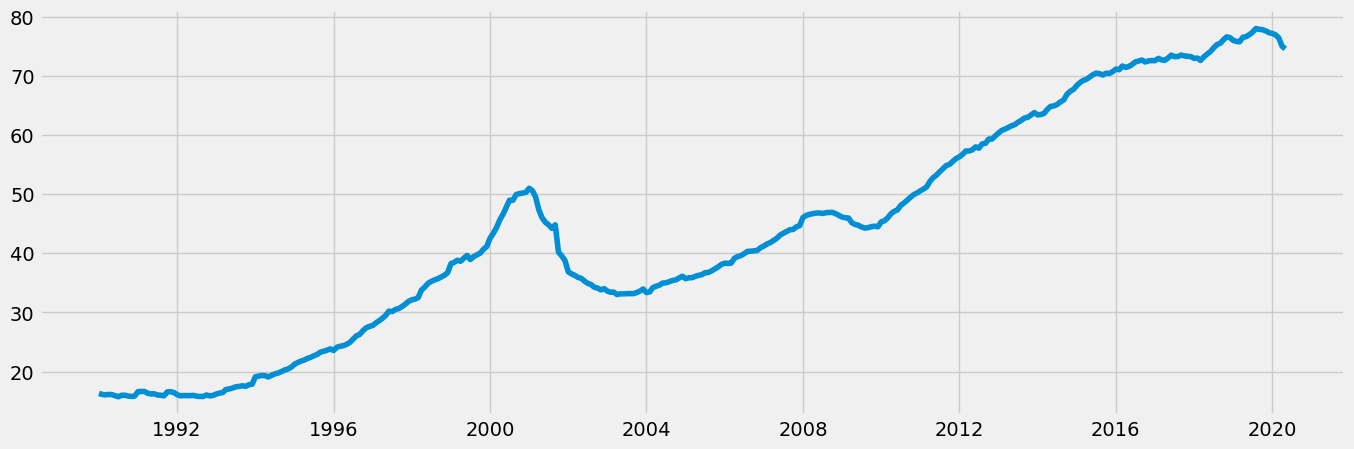

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

# Decompose the Data

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

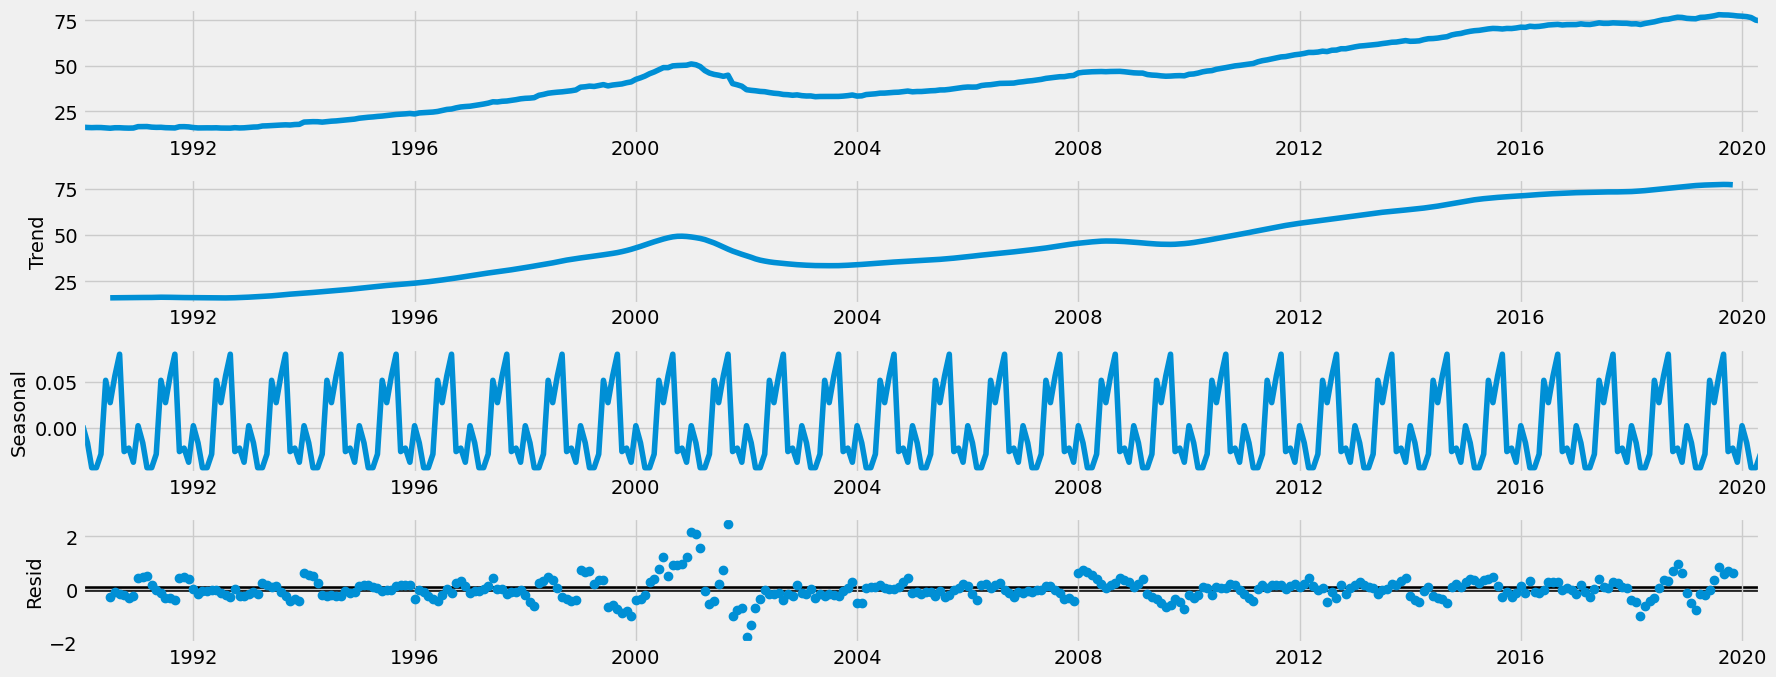

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

# Conduct Dickey-Fuller Test

In [22]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.226052
p-value                          0.662290
Number of Lags Used              6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


# Interpreting the Dickey - Fuller test
1. This data is non-stationary.  The Critical Value (5%) is larger that the Test Statistic.  This means I cannot reject the null hypothesis.  There is a unit root in this data and the data is non-stationary.

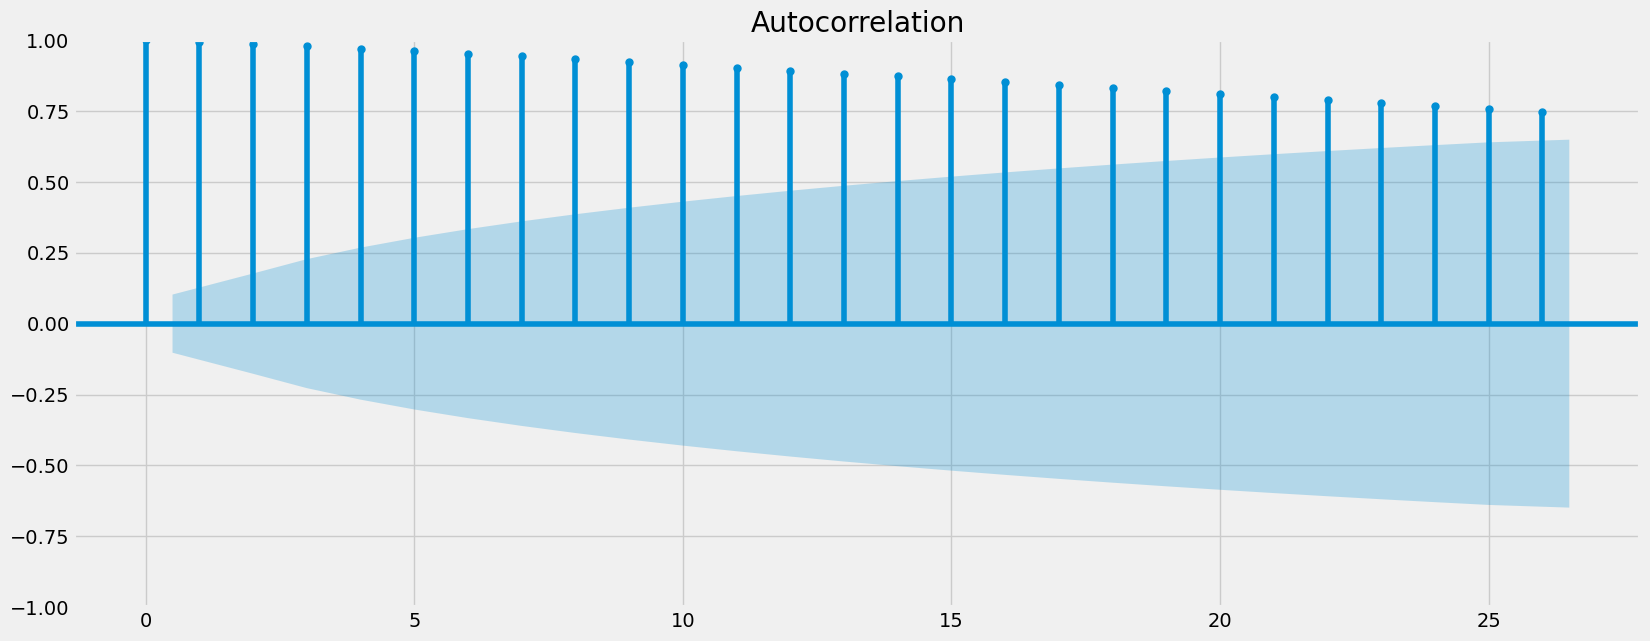

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Conduct Round of Differencing and Re-run Dickey-Fuller Test

In [24]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [25]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [26]:
data_diff.head()

,Value
datetime,
1990-02-01,-0.167824
1990-03-01,-0.078731
1990-04-01,0.071185
1990-05-01,-0.023890
1990-06-01,-0.174684


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

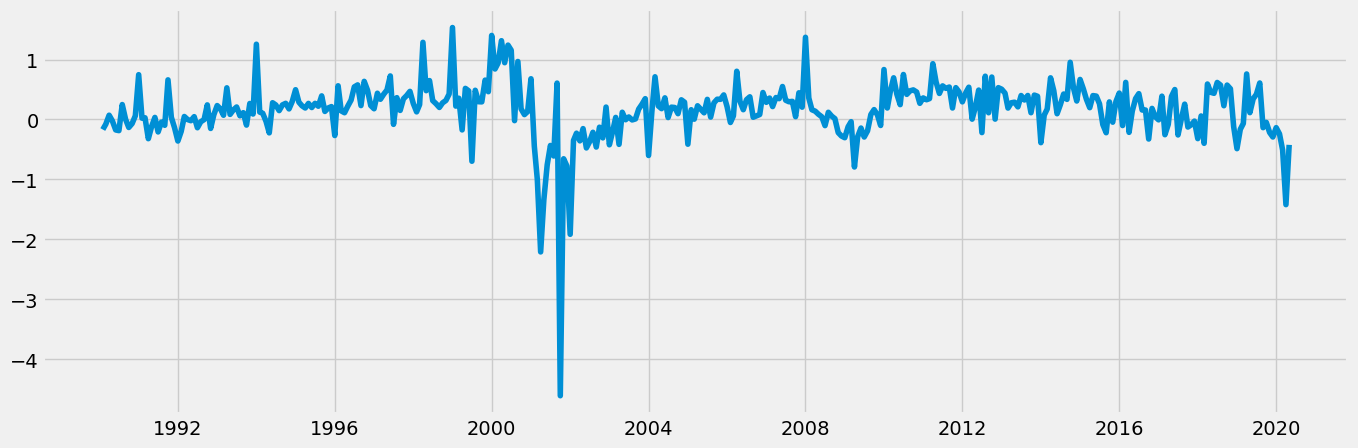

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.625137
p-value                          0.005298
Number of Lags Used              5.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


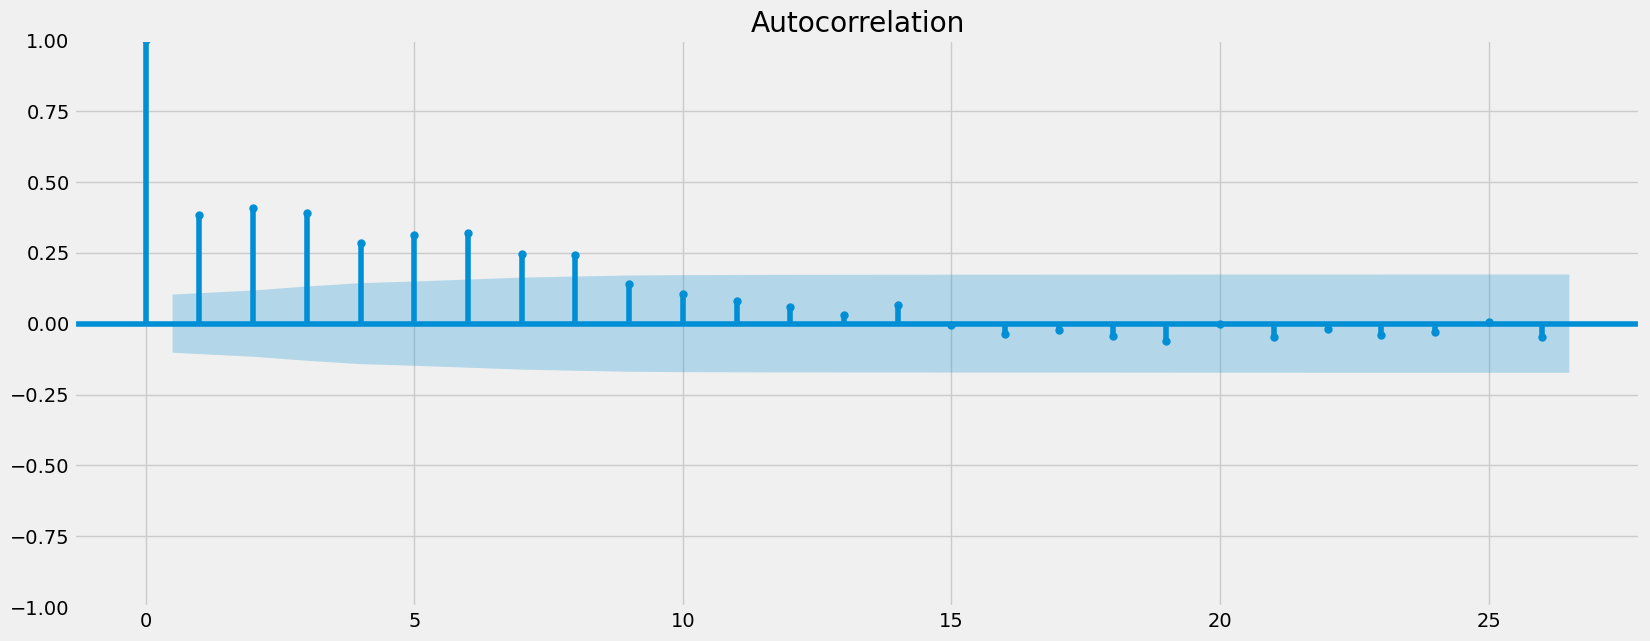

In [30]:
plot_acf(data_diff)
plt.show()

# Interpreting the Round of Differencing and Dickey-Fuller Test

This data is now stationary. The Critical Value (5%) value is smaller than the Test Statistic. This means I can reject the null hypothesis.  There is no unit root in the data and the data is stationary. 